In [1]:
import sys
sys.path.append('./models/pytorch-image-models') 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time

import torch
import openvino
import numpy as np
import torchvision
from fvcore.nn import FlopCountAnalysis

from models.swiftformer import SwiftFormer
from models.swiftformer3d import SwiftFormer3D
from models.mobilenetv3 import MobileNetV3
from models.mobilenetv2 import MobileNetV2
from models.mvit.model import MViTModel, CustomMvitModel

%load_ext autoreload
%autoreload 2

In [66]:
device = 'cpu'
torch_dtype = torch.float32
numpy_dtype = np.float32

n_skip = 5
n_runs = 10
print_step = 1
batch_shape = [1, 3, 32, 224, 224]

In [109]:
# model_kwargs = {
#     'num_classes': 1001,
#     'frame_count': 32,
#     'layers': [3, 3, 6, 4],
#     'embed_dims': [48, 56, 112, 220],
#     'temporal_indices': [4, 6],
#     'conv3d_indices': [3, 5],
#     'downsamples': [True, True, True, True],
#     'vit_num': 1,
# }
# model = SwiftFormer(**model_kwargs).eval()


# model_kwargs = {
#     'num_classes': 1001,
#     'arch': 'mobilenet_v3_large', # 'mobilenet_v3_small'
#     'frame_count': 32,
#     'temporal_indices': [10, 12, 14],
#     'conv3d_indices': [2, 4, 8],
# }
# model = MobileNetV3(**model_kwargs).eval()


# model_kwargs = {
#     'num_classes': 1001,
#     'sample_size': 224,
#     'frame_count': 32,
#     'temporal_indices': [1, 23, 4, 5, 6],
#     'width_mult': 4,
#     'with_two_heads': False,
# }
# model = MobileNetV2(**model_kwargs).eval()


# model_kwargs = {
#     'num_classes': 1001,
#     'head_channels': 384,
#     'backbone_channels': 256,
#     'arch': {
#         'embed_dims': 96,
#         'num_layers': 10,
#         'num_heads': 1,
#         'downscale_indices': [1, 3, 10]
#     },
#     # 'arch': 'small',
#     # 'pretrained': './mvit32.2_small_state_dict.pt'
# }

# model = MViTModel(**model_kwargs).eval()

# model_kwargs = {
#     'backbone': 'x2',
#     'mvit_kwargs':{
#       'num_classes': 1001,
#       'backbone_channels': 64,
#       'head_channels': 768,
#       'ignore_layers': [],
#       'arch': {
#         'embed_dims': 96,
#         'num_layers': 12,
#         'num_heads': 1,
#         'downscale_indices': [1, 3, 11],
#       },
#     }
# }

# model = CustomMvitModel(**model_kwargs).eval()

model_kwargs = {
        'num_classes': 1001,
        'frame_count': 32,
        'arch': 'l3',  # XS, S, l1, l3
        'temporal_indices': [1, 2, 3, 4, 5, 6],
        'conv3d_indices': [],
        'downsamples': [True, True, True, True],
        'vit_num': 1,
}
model = SwiftFormer3D(**model_kwargs).eval().to(device=device)

# model_kwargs = {
#         'num_classes': 1001,
#         'frame_count': 32,
#         'arch': 'l3',  # XS, S, l1, l3
#         'temporal_indices': [],
#         'conv3d_indices': [],
#         'downsamples': [True, True, True, True],
#         'vit_num': 1,
# }
# model = SwiftFormer(**model_kwargs).eval().to(device=device)

In [110]:
numpy_inputs = [np.random.randn(*batch_shape).astype(numpy_dtype) for _ in range(n_runs)]
torch_inputs = [torch.from_numpy(x).to(device=device, dtype=torch_dtype) for x in numpy_inputs]

### FLOPS CALCULATION

In [111]:
# input_tensor = torch.rand(*batch_shape).to(device=device, dtype=torch_dtype)
# flops = FlopCountAnalysis(model, input_tensor)
# total_flops = flops.total()
# print(f'GFLOPS: {total_flops / 1e9:0.2f}')

### TORCH

In [112]:
with torch.no_grad():
    for skip_num, input_data in enumerate(torch_inputs[:n_skip]):
        print(f'SKIP ITERATION {skip_num + 1}', end='\r')
        features = model(input_data)

    print('\nSTART TIME MESURING')
    torch_predicts = []
    for n_run, input_data in enumerate(torch_inputs):
        start_time = time.time()
        torch_predict = model(input_data)
        torch_predicts.append(torch_predict)
        end_time = time.time()

        time_delta = end_time - start_time
        if (n_run + 1) % print_step == 0:
            print(f'STEP: {n_run + 1} | TIME {time_delta:0.3f} SEC.')

SKIP ITERATION 5
START TIME MESURING
STEP: 1 | TIME 0.560 SEC.
STEP: 2 | TIME 0.534 SEC.
STEP: 3 | TIME 0.552 SEC.
STEP: 4 | TIME 0.532 SEC.
STEP: 5 | TIME 0.532 SEC.
STEP: 6 | TIME 0.546 SEC.
STEP: 7 | TIME 0.565 SEC.
STEP: 8 | TIME 0.532 SEC.
STEP: 9 | TIME 0.526 SEC.
STEP: 10 | TIME 0.535 SEC.


### ONNX

In [113]:
import onnx
import onnxruntime

In [114]:
dummy_input = torch.rand(*batch_shape).to(device=device, dtype=torch_dtype)
onnx_path = 'model.onnx'

torch.onnx.export(
    model, 
    dummy_input, 
    onnx_path, 
    input_names = ['input'], 
    output_names = ['output'], 
    dynamic_axes = {
        'input' : {0 : 'batch_size'},
        'output' : {0 : 'batch_size'},
    }
)

In [115]:
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
del onnx_model

In [116]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])

In [117]:
for skip_num, input_data in enumerate(numpy_inputs[:n_skip]):
    print(f'SKIP ITERATION {skip_num + 1}', end='\r')
    outputs = ort_session.run(None, {'input': input_data})

print('\nSTART TIME MESURING')
onnx_predicts = []
for n_run, input_data in enumerate(numpy_inputs):
    start_time = time.time()
    onnx_predict = ort_session.run(None, {'input': input_data})
    onnx_predicts.append(onnx_predict)
    end_time = time.time()
    
    time_delta = end_time - start_time
    if (n_run + 1) % print_step == 0:
        print(f'STEP: {n_run + 1} | TIME {time_delta:0.3f} SEC.')

SKIP ITERATION 5
START TIME MESURING
STEP: 1 | TIME 0.648 SEC.
STEP: 2 | TIME 0.656 SEC.
STEP: 3 | TIME 0.649 SEC.
STEP: 4 | TIME 0.657 SEC.
STEP: 5 | TIME 0.690 SEC.
STEP: 6 | TIME 0.659 SEC.
STEP: 7 | TIME 0.657 SEC.
STEP: 8 | TIME 0.685 SEC.
STEP: 9 | TIME 0.691 SEC.
STEP: 10 | TIME 0.678 SEC.


In [118]:
del ort_session

### OPENVINO

In [119]:
from openvino import runtime, save_model, convert_model

In [120]:
ir_path = 'model.xml'
ir_model = convert_model(onnx_path)
save_model(ir_model, ir_path)

In [121]:
core = runtime.Core()
model_ir = core.read_model(model=ir_path)
compiled_model_ir = core.compile_model(model=model_ir, device_name='CPU')

output_layer_ir = compiled_model_ir.output(0)

In [122]:
# !mo --input_model model.onnx --output_dir model

In [123]:
# xml_path = './model/model.xml'
# bin_path = './model/model.bin'

# core = runtime.Core()
# model_ir = core.read_model(model=xml_path, weights=bin_path)
# compiled_model_ir = core.compile_model(model=model_ir)

# output_layer_ir = compiled_model_ir.output(0)

In [124]:
for skip_num, input_data in enumerate(numpy_inputs[:n_skip]):
    print(f'SKIP ITERATION {skip_num + 1}', end='\r')
    res_ir = compiled_model_ir(input_data)[output_layer_ir]

print('\nSTART TIME MESURING')
openvino_predicts = []
for n_run, input_data in enumerate(numpy_inputs):
    start_time = time.time()
    openvino_predict = compiled_model_ir(input_data)[output_layer_ir]
    openvino_predicts.append(openvino_predict)
    end_time = time.time()
    
    time_delta = end_time - start_time
    if (n_run + 1) % print_step == 0:
        print(f'STEP: {n_run + 1} | TIME {time_delta:0.3f} SEC.')

SKIP ITERATION 5
START TIME MESURING
STEP: 1 | TIME 0.221 SEC.
STEP: 2 | TIME 0.221 SEC.
STEP: 3 | TIME 0.233 SEC.
STEP: 4 | TIME 0.221 SEC.
STEP: 5 | TIME 0.219 SEC.
STEP: 6 | TIME 0.227 SEC.
STEP: 7 | TIME 0.228 SEC.
STEP: 8 | TIME 0.213 SEC.
STEP: 9 | TIME 0.221 SEC.
STEP: 10 | TIME 0.216 SEC.


### CHECK PREDICTS

In [125]:
onnx_compares = []

for torch_values, onnx_values in zip(torch_predicts, onnx_predicts):
#     onnx_is_close = np.allclose(torch_values.numpy(), onnx_values, rtol=1e-01, atol=1e-01)
#     onnx_compares.append(onnx_is_close)
    torch_value = torch_values.argmax().item()
    onnx_value = np.array(onnx_predicts[0][0][0]).argmax()
    onnx_compares.append(torch_value == onnx_value)

all(onnx_compares), sum(onnx_compares) / len(onnx_compares)

(False, 0.6)

In [126]:
openvino_compares = []

for torch_values, openvino_values in zip(torch_predicts, openvino_predicts):
#     openvino_is_close = np.allclose(torch_values.numpy(), openvino_values, rtol=1e-01, atol=1e-01)
#     openvino_compares.append(openvino_is_close)
    torch_value = torch_values.argmax().item()
    openvino_value = np.array(onnx_predicts[0][0][0]).argmax()
    openvino_compares.append(torch_value == onnx_value)
    
all(openvino_compares), sum(openvino_compares) / len(openvino_compares)

(False, 0.6)

In [127]:
np.argmax(torch_values.numpy())

945

In [128]:
np.argmax(onnx_values)

945

In [129]:
np.argmax(openvino_values)

945

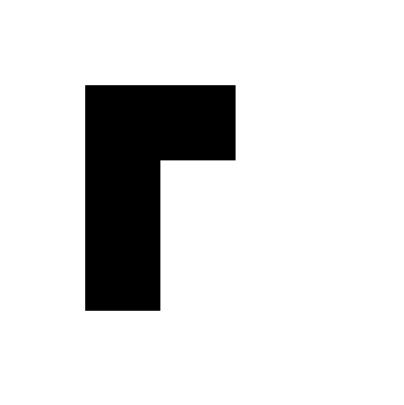

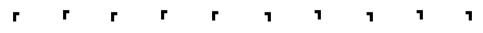

In [26]:
import torch
import numpy as np
from denku import show_image, show_images


def crop_lt(x, crop_h, crop_w):
    return x[:, :, :, 0:crop_h, 0:crop_w]

def crop_lb(x, crop_h, crop_w):
    return x[:, :, :, -crop_h:, 0:crop_w]

def crop_rt(x, crop_h, crop_w):
    return x[:, :, :, 0:crop_h, -crop_w:]

def crop_rb(x, crop_h, crop_w):
    return x[:, :, :, -crop_h:, -crop_w:]

def center_crop(x, crop_h, crop_w):
    center_h = x.shape[3] // 2
    center_w = x.shape[4] // 2
    half_crop_h = crop_h // 2
    half_crop_w = crop_w // 2

    y_min = center_h - half_crop_h
    y_max = center_h + half_crop_h + crop_h % 2
    x_min = center_w - half_crop_w
    x_max = center_w + half_crop_w + crop_w % 2

    return x[:, :, :, y_min:y_max, x_min:x_max]

def five_crops(x, crop_h, crop_w):
    return torch.cat([f(x, crop_h, crop_w) for f in [crop_lt, crop_lb, crop_rt, crop_rb, center_crop]])

def ten_crops(x, crop_h, crop_w):
    five_crop = five_crops(x, crop_h, crop_w)
    ten_crops = torch.cat([five_crop, five_crop.flip(dims=(4,))])
    return ten_crops
    
batch = torch.ones(1, 3, 2, 256, 256) * 255
batch[:, :, :, 50: 200, 50: 100] = 0
batch[:, :, :, 50: 100, 100: 150] = 0

crops = ten_crops(batch, 224, 224)
# for crop in crops:
#     print(crop.shape)

show_images([
    batch[0, :, 0, :, :].permute(1, 2, 0).numpy().astype(np.uint8),
])
show_images([
    crop[:, 0, :, :].permute(1, 2, 0).numpy().astype(np.uint8) for crop in crops
])

In [27]:
crops.shape

torch.Size([10, 3, 2, 224, 224])

In [42]:
torch.rand(2, 8).sum(dim=0).softmax(dim=0)

tensor([0.2072, 0.1240, 0.0761, 0.1932, 0.1204, 0.0766, 0.1199, 0.0825])

In [37]:
name = 'model.conv'
name[6:]

'conv'